<a href="https://colab.research.google.com/github/Hjhirp/Apple-Grading-Using-Computer-Vision/blob/main/Notebook/AppleGrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FreshGrade

/content/drive/MyDrive/FreshGrade


In [ ]:
import tensorflow as tf
import keras as k
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.utils import multi_gpu_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 8
import h5py
import glob
import cv2
import os
from datetime import date
from PIL import Image

In [ ]:
# GLOBALS
G = 2
size = 256
EPOCHS = 30
BATCH_SIZE = 32
BASE_DIR_PATH = './dataset'
MODEL_FILENAME = 'fruit_classify_model'
PATH_TO_TRAINED_MODEL_FILE = './' + MODEL_FILENAME + '.h5'

#build path to base dir
base_dir_path = BASE_DIR_PATH
#build path to train dir
train_dir_path = os.path.join(base_dir_path,'train_final_processed')
#build path to test dir
test_dir_path = os.path.join(base_dir_path,'test_final_processed')

In [ ]:
# Utilities

def readData():
    nb_of_train_files = 0
    nb_of_test_files = 0
    AllClassNames_train = os.listdir(train_dir_path)
    AllClassNames_test = os.listdir(test_dir_path)
    print('Total Number of Classes in train DataSet: ', len(AllClassNames_train))
    print('Total Number of Classes in test DataSet: ', len(AllClassNames_test))
    for class_name in AllClassNames_train:
        nb_of_train_files = nb_of_train_files + len(os.listdir(os.path.join(train_dir_path, class_name)))
        nb_of_test_files = nb_of_test_files + len(os.listdir(os.path.join(test_dir_path, class_name)))
    print('Total Number of train samples: ', nb_of_train_files)
    print('Total Number of test samples:', nb_of_test_files)
    return len(AllClassNames_train)

def plot_result(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    return

In [ ]:
# model building

def compile_classify_model(num_of_classes):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape = (size, size, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    #three layers of hidden

    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(256, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Flatten())

    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = num_of_classes, activation = 'softmax'))

    parallel_model = classifier
    #parallel_model = multi_gpu_model(classifier, gpus=G)

    parallel_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    #parallel_model.compile(optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6))
    parallel_model.summary()
    return parallel_model

def train_classify_model(classify_model, batch_size = BATCH_SIZE, save_model_filename = MODEL_FILENAME, input_size = (size,size)):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale = 1./255)

    training_set = train_datagen.flow_from_directory(train_dir_path,
                                                     target_size = (size, size),
                                                     batch_size = batch_size,
                                                     class_mode = 'categorical')

    test_set = test_datagen.flow_from_directory(test_dir_path,
                                                target_size = (size, size),
                                                batch_size = batch_size,
                                                class_mode = 'categorical')

    callback = [EarlyStopping(monitor='val_loss', patience=5),
                ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True)]

    #construct fit generator
    history = classify_model.fit_generator(training_set, epochs=EPOCHS,
                                       steps_per_epoch = training_set.n // batch_size,
                                       validation_data=test_set,
                                       validation_steps = test_set.n // batch_size,
                                       verbose=1)

    class_dict = training_set.class_indices
    print(class_dict)
    np.save('class_dict', class_dict)
    trainedModel_Filename = SaveModelFile(classify_model, save_model_filename)
    return history, trainedModel_Filename

def SaveModelFile(classify_model, save_model_filename):
    """
    Saves trained classification model

    Args:
        ClassifyModel : trained classification Model
        save_model_filename(str): filename, to save trained model,without extension.

    Returns:
        save_model_filename(str): filename with extension.
    """
    today = date.today()
    #date_str = today.strftime("%d%m%y")
    #save_model_filename = '_'.join([save_model_filename, date_str])
    save_model_filename = save_model_filename + '.h5'
    classify_model.save(save_model_filename)
    print('Done Saving Model File...')
    return save_model_filename

In [ ]:
num_of_classes = readData()

Total Number of Classes in train DataSet:  2
Total Number of Classes in test DataSet:  2
Total Number of train samples:  3778
Total Number of test samples: 996


In [ ]:
#Compile classification model
classifyModel=compile_classify_model(num_of_classes)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 64)       

In [ ]:
#Start training model on train dataset
training_history,trained_model_path = train_classify_model(classifyModel)

Found 3778 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
118/118 [==============================] - 64s 535ms/step - loss: 0.5559 - accuracy: 0.7023 - val_loss: 0.3161 - val_accuracy: 0.8831
Epoch 2/30
118/118 [==============================] - 65s 549ms/step - loss: 0.3143 - accuracy: 0.8836 - val_loss: 0.5496 - val_accuracy: 0.7409
Epoch 3/30
118/118 [==============================] - 64s 541ms/step - loss: 0.2704 - accuracy: 0.8938 - val_loss: 0.2230 - val_accuracy: 0.9224
Epoch 4/30
118/118 [==============================] - 62s 529ms/step - loss: 0.2419 - accuracy: 0.9052 - val_loss: 0.2399 - val_accuracy: 0.8962
Epoch 5/30
118/118 [==============================] - 64s 540ms/step - loss: 0.1976 - accuracy: 0.9159 - val_loss: 0.1894 - val_accuracy: 0.9204
Epoch 6/30
118/118 [==============================] - 64s 544ms/step - loss: 0.1901 - accuracy: 0.9172 - val_loss: 0.2557 - val_accuracy: 0.9083
Epoch 7/30
118/118 [==============================] - 64s 540ms/step - loss: 0.2226 - accuracy: 0.9084 - val_loss: 0.2255 - val_ac

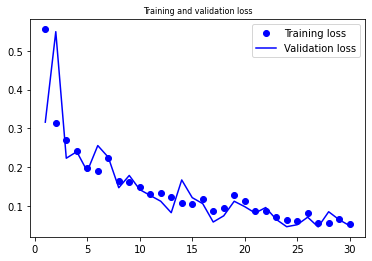

In [ ]:
#Plot the training results
plot_result(training_history)

In [ ]:
def predict_fruit_class(image_path, trained_model, class_dict):

    x = load_img(image_path, target_size=(size,size))
    x = img_to_array(x)
    # for Display Only
    import matplotlib.pyplot as plt
    plt.imshow((x * 255).astype(np.uint8), cmap='hsv')
    plt.show()
    x = np.expand_dims(x, axis=0)
    prediction_class = trained_model.predict(x)
    classes_x=np.argmax(prediction_class)
    # prediction_probs = trained_model.predict_proba(x, batch_size=1)
    # print('probs:',prediction_probs)
    print('class_index:',classes_x)
    # for key, value in class_dict.items():
    #     if value == prediction_class.item():
    #         return key
    return classes_x

In [ ]:
trained_model_path = PATH_TO_TRAINED_MODEL_FILE
trained_model = load_model(trained_model_path)
class_dict = np.load('class_dict.npy', allow_pickle=True).item()

In [ ]:
b = np.load('/content/drive/MyDrive/FreshGrade/class_dict.npy', allow_pickle=True)
b

array({'freshapples': 0, 'rottenapples': 1}, dtype=object)

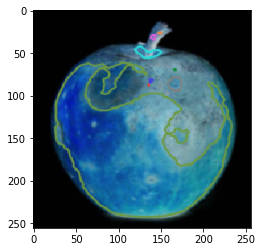

1/1 [==============================] - 0s 16ms/step
class_index: 1
['rottenapples'] 1


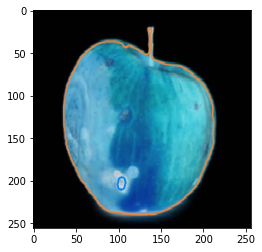

1/1 [==============================] - 0s 20ms/step
class_index: 1
['rottenapples'] 1


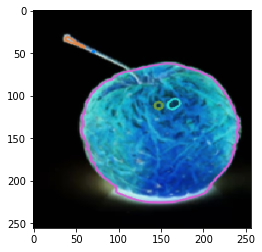

1/1 [==============================] - 0s 22ms/step
class_index: 1
['rottenapples'] 1


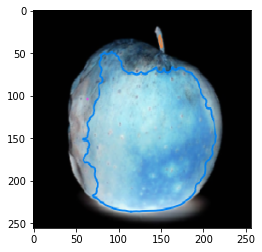

1/1 [==============================] - 0s 16ms/step
class_index: 1
['rottenapples'] 1


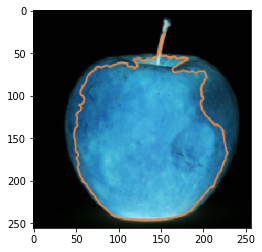

1/1 [==============================] - 0s 18ms/step
class_index: 1
['rottenapples'] 1


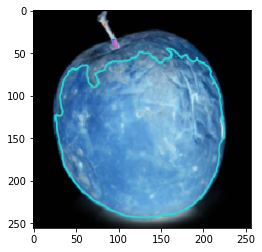

1/1 [==============================] - 0s 17ms/step
class_index: 1
['rottenapples'] 1


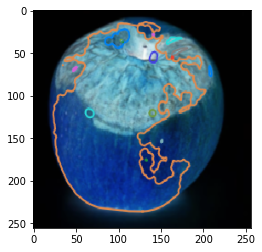

1/1 [==============================] - 0s 15ms/step
class_index: 0
['rottenapples'] 0


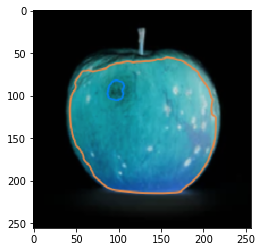

1/1 [==============================] - 0s 18ms/step
class_index: 1
['rottenapples'] 1


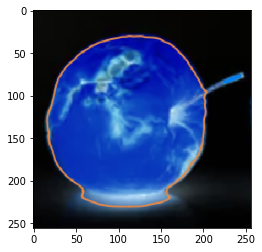

1/1 [==============================] - 0s 18ms/step
class_index: 1
['rottenapples'] 1


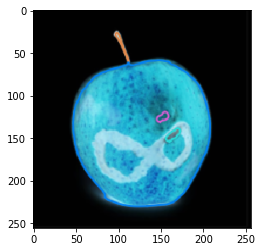

1/1 [==============================] - 0s 22ms/step
class_index: 1
['rottenapples'] 1


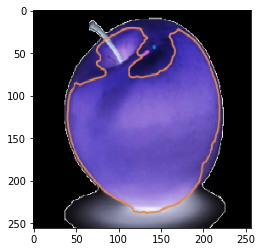

1/1 [==============================] - 0s 16ms/step
class_index: 0
['freshapples'] 0


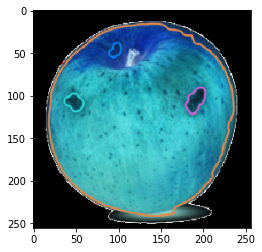

1/1 [==============================] - 0s 19ms/step
class_index: 0
['freshapples'] 0


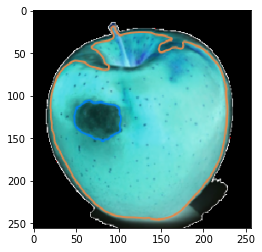

1/1 [==============================] - 0s 15ms/step
class_index: 0
['freshapples'] 0


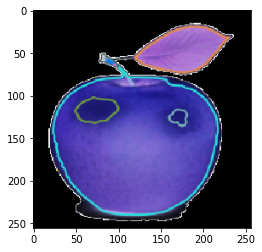

1/1 [==============================] - 0s 16ms/step
class_index: 0
['freshapples'] 0


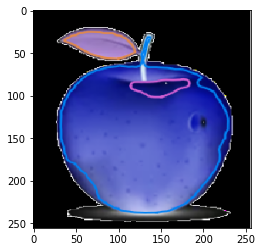

1/1 [==============================] - 0s 16ms/step
class_index: 0
['freshapples'] 0


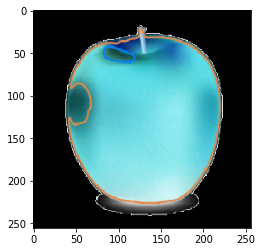

1/1 [==============================] - 0s 15ms/step
class_index: 0
['freshapples'] 0


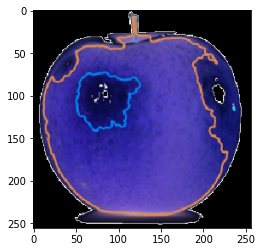

1/1 [==============================] - 0s 15ms/step
class_index: 0
['freshapples'] 0


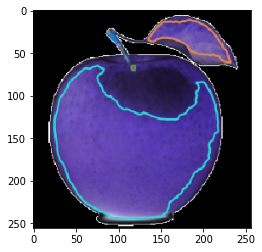

1/1 [==============================] - 0s 24ms/step
class_index: 0
['freshapples'] 0


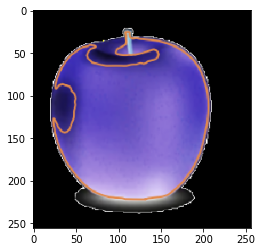

1/1 [==============================] - 0s 18ms/step
class_index: 0
['freshapples'] 0


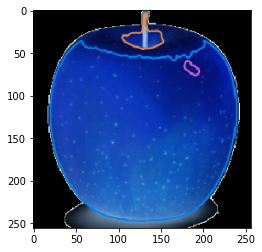

1/1 [==============================] - 0s 22ms/step
class_index: 0
['freshapples'] 0


In [ ]:
import glob
image_path = '/content/drive/MyDrive/FreshGrade/dataset/test_final_processed/rottenapples/*.png'
image_path1 = '/content/drive/MyDrive/FreshGrade/dataset/test_final_processed/freshapples/*.png'
rotten = glob.glob(image_path)[0:10]
fresh = glob.glob(image_path1)[0:10]
list_ = rotten + fresh
for i in list_:
  single_pred = predict_fruit_class(i,trained_model, class_dict)
  print(i.split('/')[-2:-1],single_pred)